In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

## 1. About Dataset

Data were extracted from images that were taken from genuine and forged banknote-like specimens. For digitization, an industrial camera usually used for print inspection was used. The final images have 400x 400 pixels. Due to the object lens and distance to the investigated object gray-scale pictures with a resolution of about 660 dpi were gained. Wavelet Transform tool were used to extract features from images.


Goal is to do binary clasification to determine if banknote is genuine or forged.


1. variance - variance of Wavelet Transformed image (continuous)
2. skewness - skewness of Wavelet Transformed image (continuous)
3. curtosis - kurtosis of Wavelet Transformed image (continuous)
4. entropy - entropy of image (continuous)
5. class

## 2. Data Preparation

### 2.1. Loading dataset

In [3]:
dataset = pd.read_csv('BankNote_Authentication.csv')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   variance  1372 non-null   float64
 1   skewness  1372 non-null   float64
 2   curtosis  1372 non-null   float64
 3   entropy   1372 non-null   float64
 4   class     1372 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 53.7 KB


In [4]:
dataset.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


At first Glance seems like there are no nan values. There are 4 features of type float and binary target variable.

In [5]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
variance,1372.0,0.433735,2.842763,-7.0421,-1.773000,0.49618,2.821475,6.8248
skewness,1372.0,1.922353,5.869047,-13.7731,-1.708200,2.31965,6.814625,12.9516
curtosis,1372.0,1.397627,4.310030,-5.2861,-1.574975,0.61663,3.179250,17.9274
entropy,1372.0,-1.191657,2.101013,-8.5482,-2.413450,-0.58665,0.394810,2.4495
class,1372.0,0.444606,0.497103,0.0000,0.000000,0.00000,1.000000,1.0000


### 2.2. Data split


Now we'll split our data into training, validation and test sets. Validation set will be used for fine tuning of the parameters and test set will be used for testing performances of the final model. We are going to use 70/15/15 split.

In [6]:
data_train, data_rest = train_test_split(dataset,test_size=0.3,random_state=42, stratify= dataset['class'])
data_val, data_test = train_test_split(data_rest,test_size=0.5,random_state=42, stratify= data_rest['class'])

## 3. EDA

### 3.1. Univariate analysis
Univariate analysis examines one variable at a time to understand its distribution, characteristics, and potential impact on the model. We'll try to understand the distribution of the data, skewness, identify outliers and see the scales of our features.

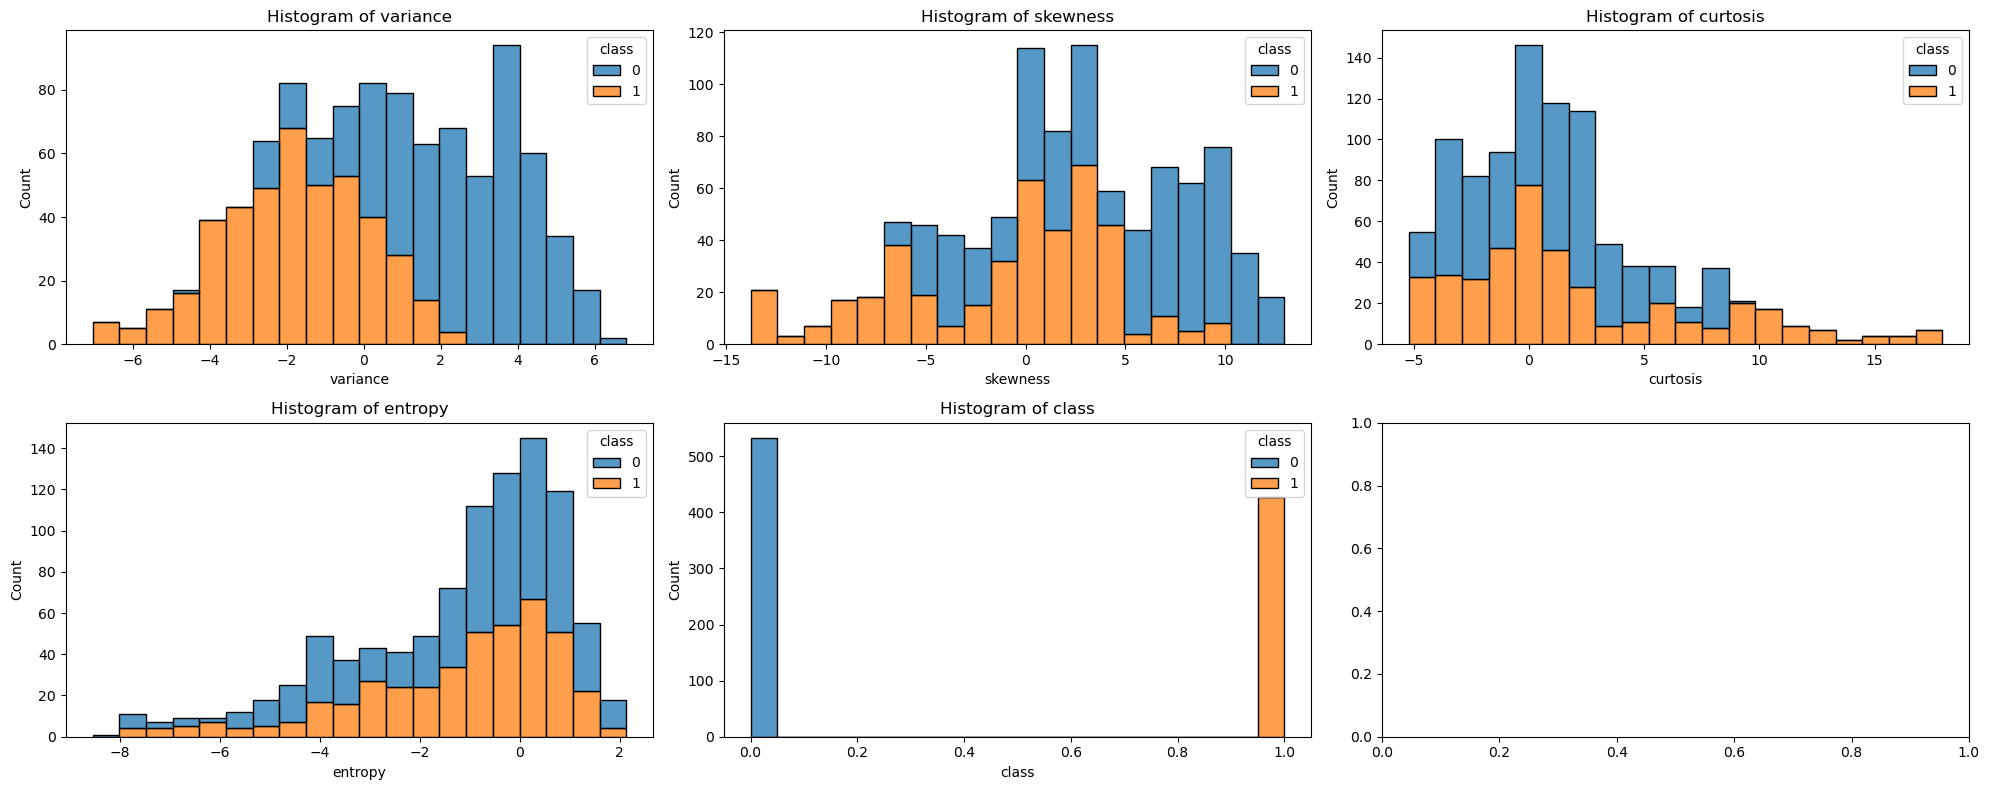

In [24]:
cols = data_train.columns

fig, axes = plt.subplots(nrows = 2, ncols=3, figsize=(20, 8))

for i, col in enumerate(cols):
    sns.histplot(data=data_train, x=col, hue='class', bins=20, multiple="stack", ax=axes[i//3,i%3])
    axes[i//3,i%3].set_title(f"Histogram of {col}")

plt.tight_layout()
plt.show()

First by the scales on x-axis we see that our dataset need to be normalized.


The variance appears to be symmetrically distributed for both classes, with a noticeable concentration around the zero mark. Class 0 shows a broader distribution to the right compared to Class 1 , which might imply that higher variance values are more common in Class 0.


For skewness class 1 shows a wider spread and tends to have more negative values then the class 0.


Kurtosis is skewed to the right. Class 1 has a higher frequency of values on the right side, suggesting that it may contain more extreme outlier observations.


Entropy displays a left-skewed distribution for both classes.


The histogram for class distribution shows imbalanced classes with a higher count for class 0.

### 3.2. Bivariate analysis

Bivariate analysis examines the relationship between two variables to understand their association, patterns, or dependencies. The goal is to determine how one variable changes with respect to another (e.g., correlation, causation, or trends).

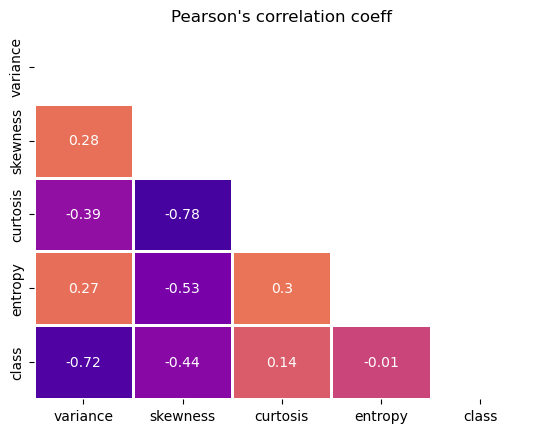

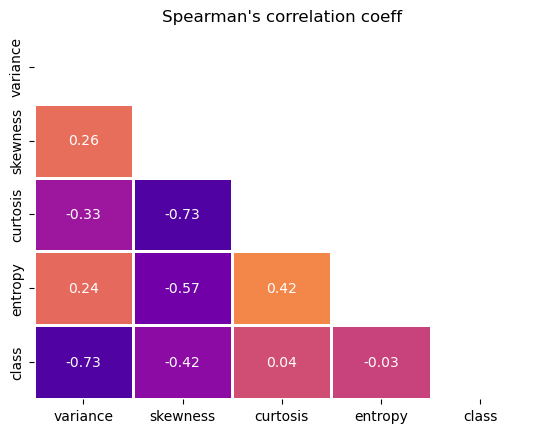

In [26]:
corr_pearson = data_train.corr(method = 'pearson').round(2)
corr_spearman = data_train.corr(method = 'spearman').round(2)
mask = np.zeros_like(corr_pearson)
for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
        mask[i][j] = j >= i
        
sns.heatmap(corr_pearson,mask=mask,vmin=-1,vmax=1,center=0, cmap='plasma',square=False,lw=2,annot=True,cbar=False)
plt.title('Pearson\'s correlation coeff')
plt.show()  


sns.heatmap(corr_spearman,mask=mask,vmin=-1,vmax=1,center=0, cmap='plasma',square=False,lw=2,annot=True,cbar=False)
plt.title('Spearman\'s correlation coeff')
plt.show()  

Variance has high negative correlation with our target, and also skewness has moderate correlation so these 2 features are important. Entropy almost has no correlation with our target, so we might consider removing it from our features as this low correaltaion suggests lack of relevance for our prediction.

Also there is high correlation between curtosis and skewness, so wee need to dealt with it to prevent multicolinearity.

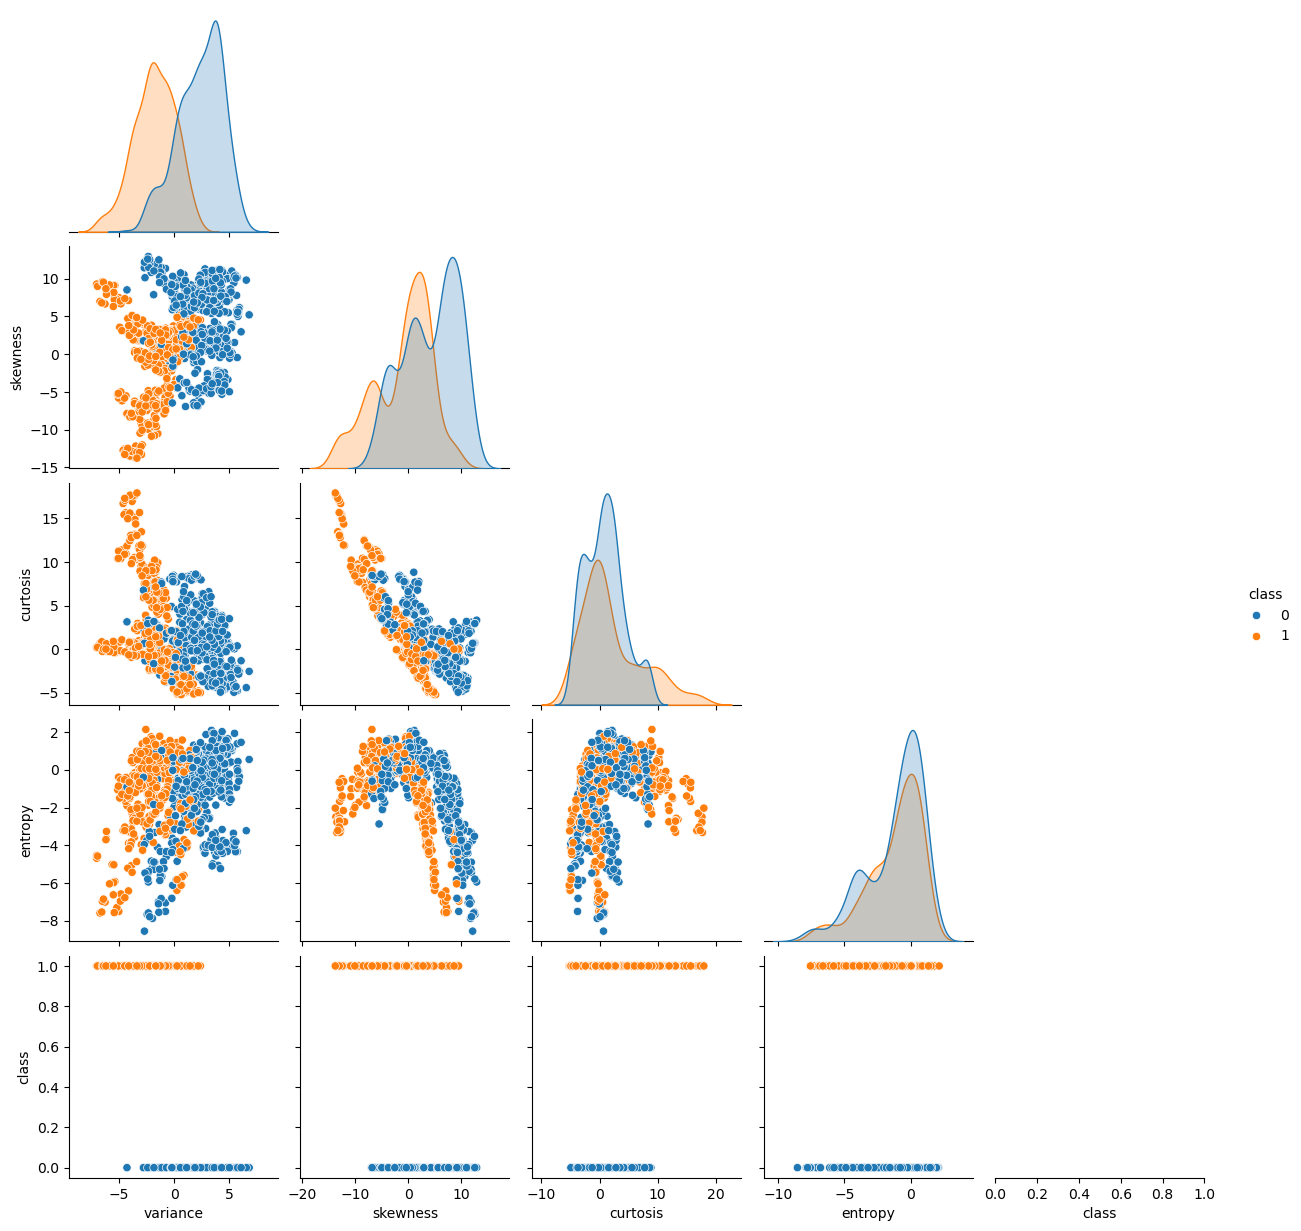

In [29]:
sns.pairplot(data_train, diag_kind="kde", corner=True, hue = 'class', vars=data_train.columns)
plt.show()

First with kde we can seee that entropy has similar distribution for both classes so it provides little to no information, while variance provides the most infomation. We see linear correlation between curtosis and variance and curtosis and skewness and nonlinear correlation between entropy and ckweness and entropy and curtosis.

## 4. Data processing

We will make 4 datsets, and then decide which one is the best. In first we will keep everything except entropy. In second we will keep only variance and skewness. In third we will do dimension reduction to 3 with PCA, and in fourth we will do dimension reduction to 2 using PCA.

### First set

In [48]:
Y1_train = data_train['class'].to_numpy()
X1_train = data_train.drop(columns=['entropy', 'class']).to_numpy()
X1_train_norm = (X1_train - X1_train.mean(axis=0)) / X1_train.std(axis=0)

Y1_test = data_test['class'].to_numpy()
X1_test = data_test.drop(columns=['entropy', 'class']).to_numpy()
X1_test_norm = (X1_test - X1_train.mean(axis=0)) / X1_train.std(axis=0)


Y1_val = data_val['class'].to_numpy()
X1_val = data_val.drop(columns=['entropy', 'class']).to_numpy()
X1_val_norm = (X1_val - X1_train.mean(axis=0)) / X1_train.std(axis=0)

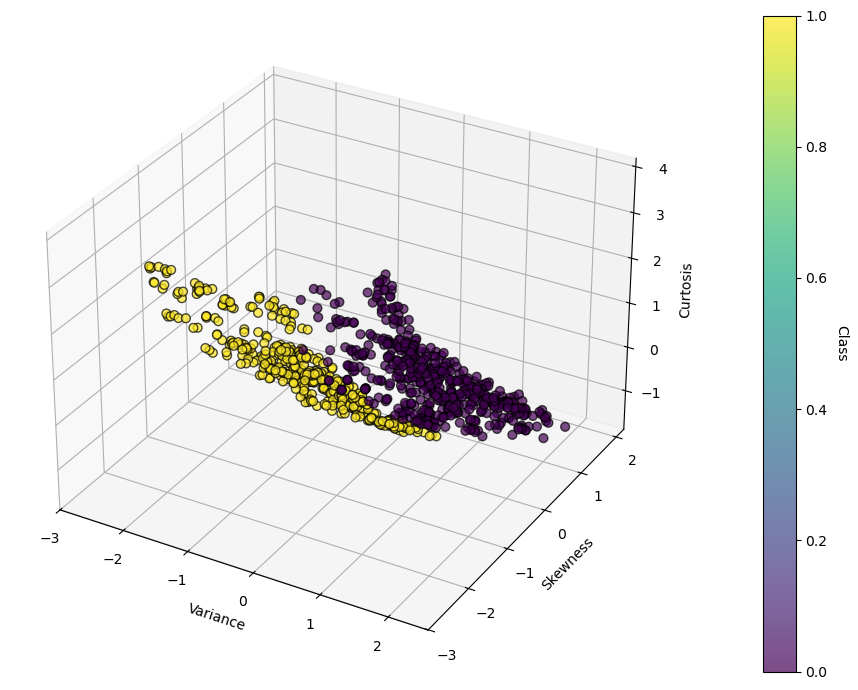

In [49]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    xs=X1_train_norm[:, 0], 
    ys=X1_train_norm[:, 1],  
    zs=X1_train_norm[:, 2],  
    c=Y1_train,             
    cmap='viridis',         
    alpha=0.7,              
    edgecolor='k',          
    s=40                   
)


ax.set_xlabel('Variance', fontsize=10)
ax.set_ylabel('Skewness', fontsize=10)
ax.set_zlabel('Curtosis', fontsize=10)

cbar = fig.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Class', rotation=270, labelpad=15)

plt.tight_layout()
plt.show()

### Second set

In [42]:
Y2_train = data_train['class'].to_numpy()
X2_train = data_train.drop(columns=['entropy', 'class', 'curtosis']).to_numpy()
X2_train_norm = (X2_train - X2_train.mean(axis=0)) / X2_train.std(axis=0)

Y2_test = data_test['class'].to_numpy()
X2_test = data_test.drop(columns=['entropy', 'class', 'curtosis']).to_numpy()
X2_test_norm = (X2_test - X2_train.mean(axis=0)) / X2_train.std(axis=0)


Y2_val = data_val['class'].to_numpy()
X2_val = data_val.drop(columns=['entropy', 'class', 'curtosis']).to_numpy()
X2_val_norm = (X2_val - X2_train.mean(axis=0)) / X2_train.std(axis=0)

Text(0, 0.5, 'skewness')

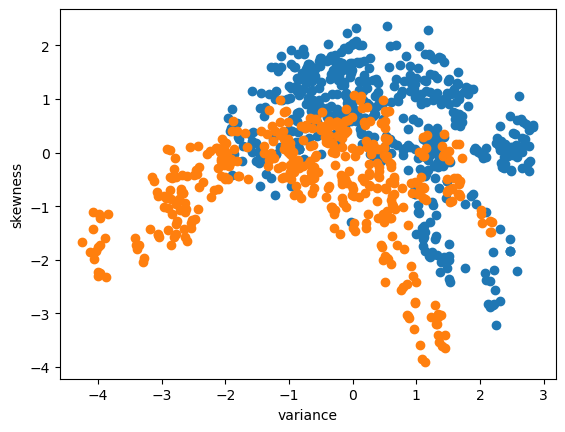

In [55]:
plt.figure()
plt.scatter(X4_train_pca[Y4_train==0, 0], X4_train_pca[Y4_train==0, 1])
plt.scatter(X4_train_pca[Y4_train==1, 0], X4_train_pca[Y4_train==1, 1])
plt.xlabel('variance')
plt.ylabel('skewness')

### Third set

In [45]:
Y3_train = data_train['class'].to_numpy()
X3_train = data_train.drop(columns=['class']).to_numpy()
X3_train_norm = (X3_train - X3_train.mean(axis=0)) / X3_train.std(axis=0)

Y3_test = data_test['class'].to_numpy()
X3_test = data_test.drop(columns=['class']).to_numpy()
X3_test_norm = (X3_test - X3_train.mean(axis=0)) / X3_train.std(axis=0)


Y3_val = data_val['class'].to_numpy()
X3_val = data_val.drop(columns=['class']).to_numpy()
X3_val_norm = (X3_val - X3_train.mean(axis=0)) / X3_train.std(axis=0)

pca = PCA(n_components=3)
X3_train_pca = pca.fit_transform(X3_train_norm)
X3_test_pca = pca.transform(X3_test_norm)
X3_val_pca = pca.transform(X3_val_norm)

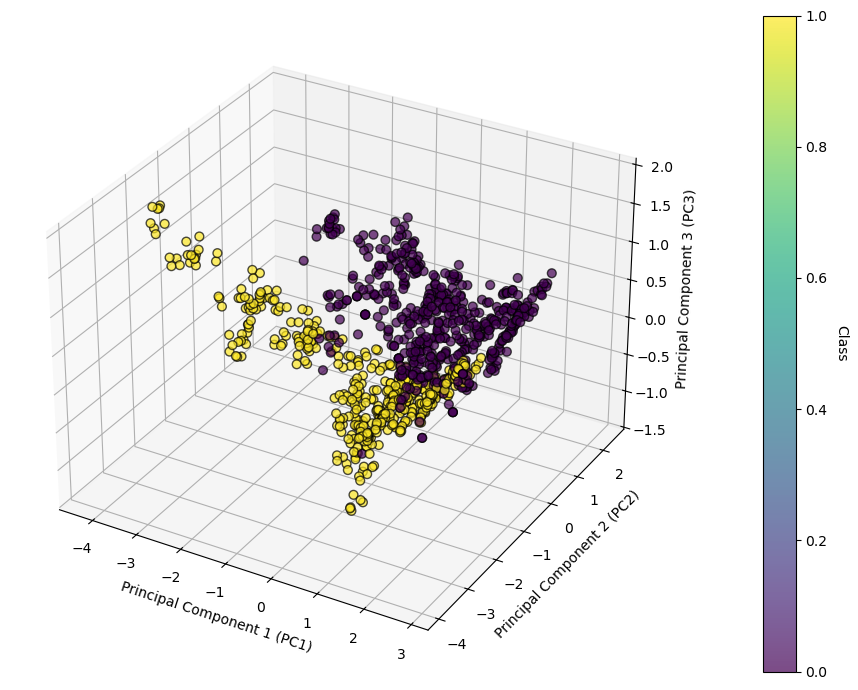

In [52]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    xs=X3_train_pca[:, 0],  
    ys=X3_train_pca[:, 1],  
    zs=X3_train_pca[:, 2], 
    c=Y3_train,             
    cmap='viridis',         
    alpha=0.7,              
    edgecolor='k',          
    s=40                   
)

ax.set_xlabel('Principal Component 1 (PC1)', fontsize=10)
ax.set_ylabel('Principal Component 2 (PC2)', fontsize=10)
ax.set_zlabel('Principal Component 3 (PC3)', fontsize=10)

cbar = fig.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Class', rotation=270, labelpad=15)

plt.tight_layout()
plt.show()

### Fourth Set

In [46]:
Y4_train = data_train['class'].to_numpy()
X4_train = data_train.drop(columns=['class']).to_numpy()
X4_train_norm = (X4_train - X4_train.mean(axis=0)) / X4_train.std(axis=0)

Y4_test = data_test['class'].to_numpy()
X4_test = data_test.drop(columns=['class']).to_numpy()
X4_test_norm = (X4_test - X4_train.mean(axis=0)) / X4_train.std(axis=0)

Y4_val = data_val['class'].to_numpy()
X4_val = data_val.drop(columns=['class']).to_numpy()
X4_val_norm = (X4_val - X4_train.mean(axis=0)) / X4_train.std(axis=0)

pca = PCA(n_components=2)
X4_train_pca = pca.fit_transform(X4_train_norm)
X4_test_pca = pca.transform(X4_test_norm)
X4_val_pca = pca.transform(X4_val_norm)

Text(0, 0.5, 'Principal Component 2 (PC2)')

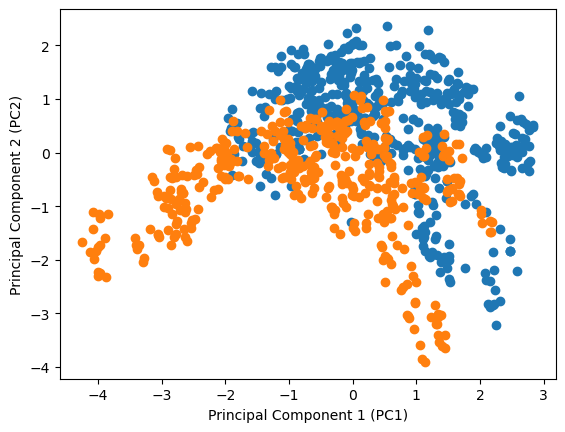

In [54]:
plt.figure()
plt.scatter(X4_train_pca[Y4_train==0, 0], X4_train_pca[Y4_train==0, 1])
plt.scatter(X4_train_pca[Y4_train==1, 0], X4_train_pca[Y4_train==1, 1])
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')

From plot we can notice that only 2 components aren't enough for good classification, so we will be only using sets 1 and 3 and then determine which one suits us better.

## 5. Logistic Regression Model

In [88]:
class LogisticRegression():
    def __init__(self, lr = 0.001, max_epochs = 1000, eps = 1e-15):
        self.lr = lr
        self.max_epochs = max_epochs
        self.eps = eps
        self.theta = None
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def fit(self, X, Y):
        Y = Y.reshape(-1, 1)
        self.theta = np.zeros((X.shape[1], 1))
        
        for i in range(self.max_epochs):
            prev_theta = self.theta.copy()
            h = self.sigmoid(X @ self.theta)
            self.theta += self.lr * X.T @ (Y-h) / X.shape[0]
        
            if np.linalg.norm(self.theta - prev_theta) < self.eps:
                    break
                    
    def predict(self, X):
        return (self.sigmoid(X @ self.theta) > 0.5).astype(int)

### First Set

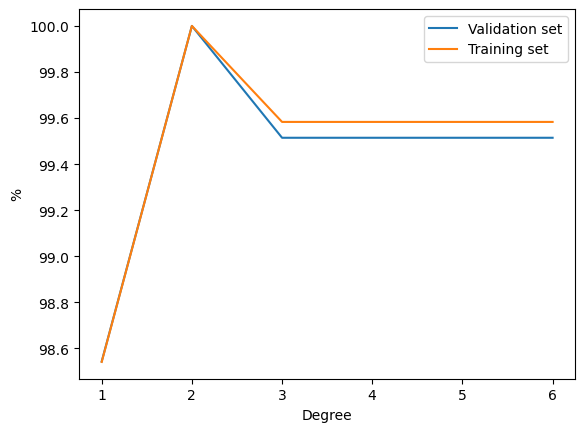

In [114]:
per_train = []
per_val = []
n = 6
for i in range(1, n+1):
    lr = LogisticRegression(lr = 0.01, max_epochs= 100000)
    poly = PolynomialFeatures(degree=i, include_bias=True)
    X1_train_poly = poly.fit_transform(X1_train_norm)
    X1_val_poly = poly.transform(X1_val_norm)
    lr.fit(X1_train_poly, Y1_train)
    Y1_train_pred = lr.predict(X1_train_poly)
    Y1_val_pred = lr.predict(X1_val_poly)
    cm_train = confusion_matrix(Y1_train_pred, Y1_train)
    cm = confusion_matrix(Y1_val_pred, Y1_val)
    per_val.append(cm.trace()/np.sum(cm) * 100)
    per_train.append(cm_train.trace()/np.sum(cm_train) * 100)
plt.figure()
plt.plot(np.arange(1,n+1), per_val)
plt.plot(np.arange(1,n+1), per_train)
plt.xlabel('Degree')
plt.ylabel('%')
plt.legend(['Validation set', 'Training set'])

In [115]:
print(f'Best fit is degree {np.argmax(per_val)+1} wit acc. of {max(per_val)}%')

Best fit is degree 2 wit acc. of 100.0%


### Second Set

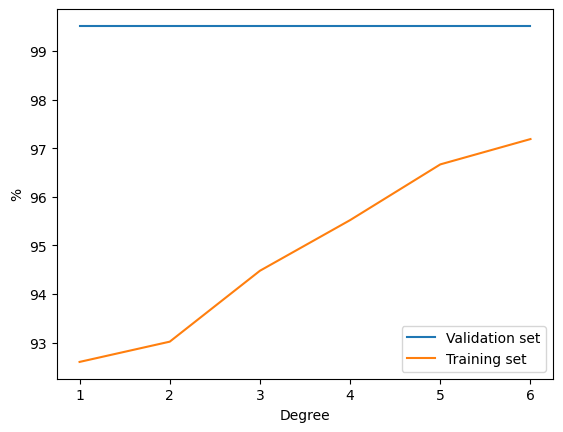

In [116]:
per_train = []
per_val = []
n = 6
for i in range(1, n+1):
    lr = LogisticRegression(lr = 0.01, max_epochs= 100000)
    poly = PolynomialFeatures(degree=i, include_bias=True)
    X3_train_polypca = poly.fit_transform(X3_train_pca)
    X3_val_polypca = poly.transform(X3_val_pca)
    lr.fit(X3_train_polypca, Y3_train)
    Y3_train_pred = lr.predict(X3_train_polypca)
    Y3_val_pred = lr.predict(X3_val_polypca)
    cm_train = confusion_matrix(Y3_train_pred, Y3_train)
    cm = confusion_matrix(Y1_val_pred, Y1_val)
    per_val.append(cm.trace()/np.sum(cm) * 100)
    per_train.append(cm_train.trace()/np.sum(cm_train) * 100)
plt.figure()
plt.plot(np.arange(1,n+1), per_val)
plt.plot(np.arange(1,n+1), per_train)
plt.xlabel('Degree')
plt.ylabel('%')
plt.legend(['Validation set', 'Training set'])

In [117]:
print(f'Best fit is degree {np.argmax(per_val)+1} wit acc. of {max(per_val)}%')

Best fit is degree 1 wit acc. of 99.51456310679612%


### Performance on test set

Best fitting model is 2nd degree ploynomial Logistic Regression on the first dataset, so let's now see how it is performing on test set

<Axes: >

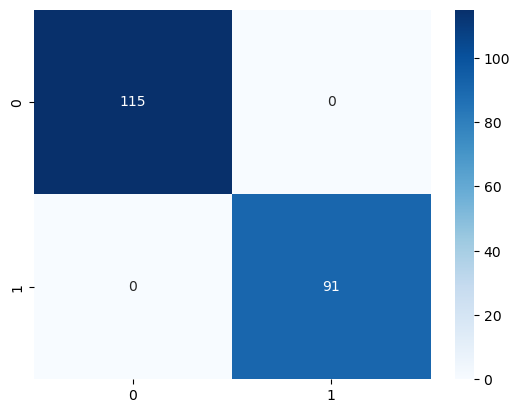

In [119]:
lr = LogisticRegression(lr = 0.01, max_epochs= 100000)
poly = PolynomialFeatures(degree=2, include_bias=True)
X1_train_poly = poly.fit_transform(X1_train_norm)
X1_test_poly = poly.transform(X1_test_norm)
lr.fit(X1_train_poly, Y1_train)
Y1_test_pred = lr.predict(X1_test_poly)
cm = confusion_matrix(Y1_test, Y1_test_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")